In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def get_datetime_id():
    return datetime.datetime.now().strftime('%h-%d-%y_%H-%M-00')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip files that we need

In [ ]:
!unzip /content/drive/MyDrive/cbis-ddsm-zips/mass_only.zip -d /content/cbis-ddsm/

In [3]:
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE + (3,))
BATCH_SIZE = 100

In [4]:
data_dir = '/content/cbis-ddsm/train/'
ds_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=(224,224),
                                                               batch_size=BATCH_SIZE)

Found 12470 files belonging to 2 classes.


In [5]:
data_dir = '/content/cbis-ddsm/valid/'
ds_valid = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=(224,224),
                                                               batch_size=BATCH_SIZE)

Found 1280 files belonging to 2 classes.


In [6]:
num_classes = len(ds_train.class_names)
BUFFER_SIZE = 250
STEPS_PER_EPOCH = 20 

In [7]:
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
valid_dataset = ds_valid.cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Transfer Learning Binary Classification

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze convolution base
base_model.trainable = False

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001/10
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [ ]:
initial_epochs = 60
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/60
20/20 [==============================] - 7s 238ms/step - loss: 0.9260 - accuracy: 0.4619 - val_loss: 0.9220 - val_accuracy: 0.4758
Epoch 2/60
20/20 [==============================] - 4s 203ms/step - loss: 0.8722 - accuracy: 0.4848 - val_loss: 0.8954 - val_accuracy: 0.4805
Epoch 3/60
20/20 [==============================] - 4s 203ms/step - loss: 0.8755 - accuracy: 0.4790 - val_loss: 0.8707 - val_accuracy: 0.4883
Epoch 4/60
20/20 [==============================] - 4s 202ms/step - loss: 0.8412 - accuracy: 0.4924 - val_loss: 0.8484 - val_accuracy: 0.4891
Epoch 5/60
20/20 [==============================] - 4s 201ms/step - loss: 0.8301 - accuracy: 0.4840 - val_loss: 0.8290 - val_accuracy: 0.4992
Epoch 6/60
20/20 [==============================] - 4s 202ms/step - loss: 0.8005 - accuracy: 0.4800 - val_loss: 0.8127 - val_accuracy: 0.5016
Epoch 7/60
20/20 [==============================] - 4s 204ms/step - loss: 0.7992 - accuracy: 0.4867 - val_loss: 0.7979 - val_accuracy: 0.5094
Epoch 

Fine Tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

Epoch 60/110
20/20 [==============================] - 9s 298ms/step - loss: 0.6966 - accuracy: 0.5229 - val_loss: 0.6582 - val_accuracy: 0.5930
Epoch 61/110
20/20 [==============================] - 5s 259ms/step - loss: 0.6710 - accuracy: 0.5448 - val_loss: 0.6512 - val_accuracy: 0.6070
Epoch 62/110
20/20 [==============================] - 5s 255ms/step - loss: 0.6616 - accuracy: 0.5767 - val_loss: 0.6347 - val_accuracy: 0.6039
Epoch 63/110
20/20 [==============================] - 5s 258ms/step - loss: 0.6692 - accuracy: 0.5571 - val_loss: 0.6570 - val_accuracy: 0.6359
Epoch 64/110
20/20 [==============================] - 5s 258ms/step - loss: 0.6451 - accuracy: 0.5976 - val_loss: 0.6263 - val_accuracy: 0.6133
Epoch 65/110
20/20 [==============================] - 5s 258ms/step - loss: 0.6425 - accuracy: 0.5938 - val_loss: 0.6331 - val_accuracy: 0.6320
Epoch 66/110
20/20 [==============================] - 5s 259ms/step - loss: 0.6384 - accuracy: 0.5990 - val_loss: 0.6282 - val_accuracy:

Fine Tuning 2

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
fine_tune_epochs = 50
total_epochs =  total_epochs + fine_tune_epochs

history_fine2 = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

Epoch 110/160
20/20 [==============================] - 10s 350ms/step - loss: 0.5150 - accuracy: 0.7143 - val_loss: 0.6046 - val_accuracy: 0.6797
Epoch 111/160
20/20 [==============================] - 6s 312ms/step - loss: 0.5096 - accuracy: 0.7281 - val_loss: 0.6025 - val_accuracy: 0.6797
Epoch 112/160
20/20 [==============================] - 6s 312ms/step - loss: 0.5171 - accuracy: 0.7133 - val_loss: 0.6054 - val_accuracy: 0.6797
Epoch 113/160
20/20 [==============================] - 6s 312ms/step - loss: 0.5210 - accuracy: 0.7262 - val_loss: 0.6010 - val_accuracy: 0.6820
Epoch 114/160
20/20 [==============================] - 6s 310ms/step - loss: 0.5150 - accuracy: 0.7237 - val_loss: 0.5995 - val_accuracy: 0.6844
Epoch 115/160
20/20 [==============================] - 6s 313ms/step - loss: 0.5397 - accuracy: 0.6976 - val_loss: 0.6035 - val_accuracy: 0.6805
Epoch 116/160
20/20 [==============================] - 6s 314ms/step - loss: 0.5227 - accuracy: 0.7143 - val_loss: 0.6023 - val_a

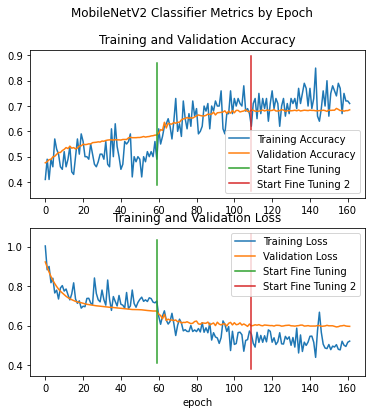

In [ ]:
acc = history.history['accuracy'].copy()
val_acc = history.history['val_accuracy'].copy()
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss = history.history['loss'].copy()
val_loss = history.history['val_loss'].copy()
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

fig = plt.figure(figsize=(6, 6))
plt.suptitle('MobileNetV2 Classifier Metrics by Epoch')

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig(f'training_by_epoch{get_datetime_id()}.png',dpi=300)

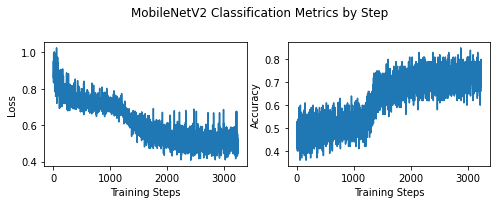

In [ ]:
fig2 = plt.figure(figsize=(8,5))
plt.suptitle('MobileNetV2 Classification Metrics by Step')

plt.subplot(2, 2, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 2, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

fig2.savefig(f'training_by_steps{get_datetime_id()}.png',dpi=300)

Train from Scratch

In [9]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None) # use None for randomization

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [11]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [13]:
#batch_stats_callback = CollectBatchStats()
initial_epochs = 200
history_baseline = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/200
20/20 [==============================] - 60s 961ms/step - loss: 0.6929 - accuracy: 0.5280 - val_loss: 0.6902 - val_accuracy: 0.5938
Epoch 2/200
20/20 [==============================] - 16s 761ms/step - loss: 0.6916 - accuracy: 0.5409 - val_loss: 0.6859 - val_accuracy: 0.5938
Epoch 3/200
20/20 [==============================] - 15s 771ms/step - loss: 0.6930 - accuracy: 0.5137 - val_loss: 0.6861 - val_accuracy: 0.5938
Epoch 4/200
20/20 [==============================] - 15s 761ms/step - loss: 0.6910 - accuracy: 0.5364 - val_loss: 0.6869 - val_accuracy: 0.5938
Epoch 5/200
20/20 [==============================] - 15s 763ms/step - loss: 0.6916 - accuracy: 0.5310 - val_loss: 0.6869 - val_accuracy: 0.5938
Epoch 6/200
20/20 [==============================] - 15s 769ms/step - loss: 0.6938 - accuracy: 0.5006 - val_loss: 0.6880 - val_accuracy: 0.5938
Epoch 7/200
20/20 [==============================] - 15s 760ms/step - loss: 0.6927 - accuracy: 0.5163 - val_loss: 0.6883 - val_accuracy: